In [1]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
#import GCN as GCN
#import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
from Full_model import Integrated_Model

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

name: X_test
shape: (640, 31, 1518)
-----------------------
name: X_train
shape: (640, 31, 1395)
-----------------------
name: clip_sizes_test
shape: (2, 129)
-----------------------
name: clip_sizes_train
shape: (2, 127)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1518)
-----------------------
name: sel_win_nums_train
shape: (1, 1395)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1518)
-----------------------
name: y_train
shape: (1, 1395)
-----------------------
print sample EGG signal from one node:


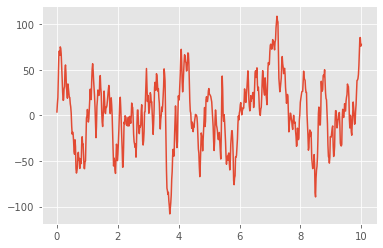

In [528]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_620.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = True)

In [529]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [530]:
print(dm)
dm.apply_dvariance_filter(28)
dm.mean_pooling_1d(size = 24, stride = 20, padding = 0)
print(dm)

X_train: shape of(1387, 31, 640)
X_test: shape of(1487, 31, 640)
Y_train: shape of(1387, 1)
Y_test: shape of(1487, 1)
A_train: shape of(31, 31)
A_test: shape of(31, 31)
P_avg_train: shape of(31, 31)
P_avg_test: shape of(31, 31)
--------data successfully filtered (dvariance)--------
X_train: shape of(1387, 28, 31)
X_test: shape of(1487, 28, 31)
Y_train: shape of(1387, 1)
Y_test: shape of(1487, 1)
A_train: shape of(28, 28)
A_test: shape of(28, 28)
P_avg_train: shape of(28, 28)
P_avg_test: shape of(28, 28)


In [531]:
def normalize(X):
    X_bar = np.mean(X, axis=2, keepdims=True)
    # buid P matrix (tensor since there are M examples) shape: MxNxN
    return (X - X_bar) / np.std(X, axis=2, keepdims = True) 

N = dm.X_train.shape[1]
D = dm.X_train.shape[2]
tensor = torch.normal(0, 1, size=(N, D))
#tensor = torch.mean(torch.tensor(normalize(dm.X_train)).float(), dim = 0)

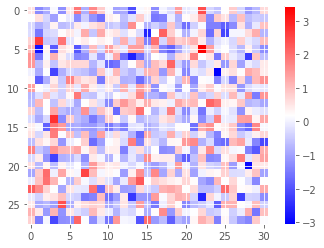

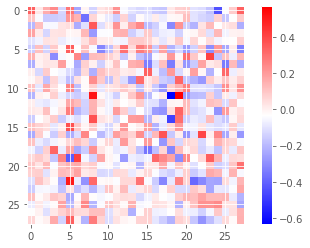

In [532]:

        
show_heat_map(tensor)
normalized_train = normalize(dm.X_train)
#show_heat_map(torch.matmul(torch.tensor(normalized_train[0]).float(), tensor.T))
P = torch.matmul(torch.tensor(normalized_train).float(), tensor.T)
P = torch.mean(P, dim=0).numpy()
show_heat_map(P)

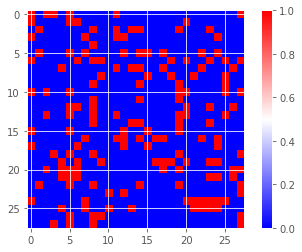

(28, 28)


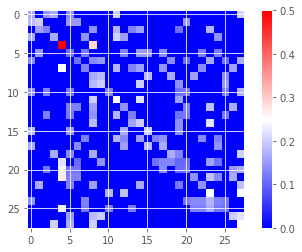

In [533]:
def create_DAD_no_diag(adj):
    rowsum = np.sum(adj, axis=1)
    D = np.zeros(adj.shape)
    for i, rs in enumerate(rowsum):
        if rs != 0:
            D[i,:] = adj[i,:] / rs
    #D = fractional_matrix_power(D, -0.5)
    #print(D)
    return D@adj@D

Araw = P>0.1
show_heat_map(Araw)
print(Araw.shape)
show_heat_map(create_DAD(Araw))

In [534]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ',' \
               + str(self.out_features) + ')'

    def reset_parameters(self):
        stdv = 1. / self.weight.size(1) ** 1 / 2
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    # H, feature matrix
    # A, precomputed adj matrix
    def forward(self, H, A):
        n = torch.matmul(A, torch.matmul(H, self.weight))
        if self.bias is not None:
            return n + self.bias
        else:
            return n


class SimularityMatrix(nn.Module):
    def __init__(self, in_features):
        super(SimularityMatrix, self).__init__()
        self.in_features = in_features

        self.weight = nn.Parameter(torch.Tensor(in_features))
        # self.weight = torch.squeeze(self.weight)

        self.reset_parameters()

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ')'

    def reset_parameters(self):
        stdv = 1. / self.weight.size(0) ** 1 / 2
        self.weight.data.uniform_(-stdv, stdv)

    # computes the simularity matrix:
    # H, feature matrix --> N x D
    # A, precomputed adj matrix --> NxN

    def forward(self, H, H0, tensor):
        # get hidden state (concate H0 and H)
        Z = torch.cat((H0, H), 2)
        tensor_cat = torch.cat((tensor, tensor), 1)
        # centering normalize Z
        Z = self.fcn(Z)
        tensor_cat = self.fcn(torch.reshape(tensor_cat, (1, *tensor_cat.shape)))
        #print(Z.shape,tensor_cat.shape)
        theta = torch.diag(self.weight)
        sim_matrix = torch.matmul(torch.matmul(Z, theta), torch.transpose(tensor_cat, 1, 2))
        return sim_matrix

    # simularity between node u and node v (shape Mx1xD)
    # return the u,v index of the simularity matrix
    def get_sim(self, u, v):
        theta = torch.diag(self.weight)
        # print(self.weight)
        # print(u.shape, theta.shape, self.weight.shape, torch.transpose(v, 1, 2).shape)
        return torch.squeeze(torch.matmul(torch.matmul(u, theta), torch.transpose(v, 1, 2)))

    def get_sim_vectorized(self, Z):  # Z is M x N Sx 2D
        theta = torch.diag(self.weight)
        sim_matrix = torch.matmul(torch.matmul(Z, theta), torch.transpose(Z, 1, 2))
        return sim_matrix

    # centering-normalizing (CN) operator
    def fcn(self, Z):
        norm_Z = (Z - torch.mean(Z, dim=2, keepdim=True))
        return norm_Z / torch.std(Z, unbiased=True, dim=2, keepdim=True)
        # (((1/(self.in_features-1)) * torch.sum(norm_Z**2, dim = 2, keepdim = True))**(1/2))


# n-layer GCN Network
class Net(nn.Module):
    def __init__(self, body_features, n_layers, activation = F.relu, bias=False):
        super(Net, self).__init__()
        assert(n_layers >= 1)
        self.activation = activation
        self.head = GCN(body_features, body_features, bias)
        self.layers = nn.ModuleList()
        for i in range(n_layers - 1):
            self.layers.append(GCN(body_features, body_features, bias))
        self.tail = SimularityMatrix(body_features*2) #SimilarityMatrixApproximate(28, body_features*2)

    def forward(self, h_0, A, tensor):
        #print(h_0.shape)
        x = self.activation(self.head(h_0, A))
        for layer in self.layers:
            x = self.activation(layer(x, A))
        sim_matrix = self.tail(x, h_0, tensor)
        return sim_matrix

    def get_embeddings(self, h_0, A):
        x = self.activation(self.head(h_0, A))
        for layer in self.layers:
            x = self.activation(layer(x, A))
        return x


class sim_loss(torch.nn.Module):

    def __init__(self):
        super(sim_loss, self).__init__()

    def forward(self, sim_matrix, A, epsilon=1e-8):
        A_tf = (A != 0)
        M = sim_matrix.shape[0]
        abs_N = torch.sum(A_tf, dim=1, keepdim=True)  # Nx1 matrix

        logexp_S = torch.log(torch.sum(torch.exp(sim_matrix), dim=2, keepdim=True))

        obj_vector = (torch.sum(A_tf * sim_matrix, dim=2, keepdim=True) - abs_N * logexp_S)
        return -(1 / M) * torch.sum(obj_vector)

In [535]:
from tqdm import tqdm

def train_GCN(A, X_train, X_test, checkpoint, tensor, device_name='cpu', load=False, print_summary=True):
    # preprocess inputs
    A = torch.from_numpy(A).float()
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    if device_name == 'cuda':
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        print("device set to cuda") if device == torch.device('cuda') else print("cuda is not available")
    elif device_name == 'cpu':
        device = torch.device('cpu')
        print("device set to cpu")
    else:
        device = torch.device('cpu')
        print("unknown device")
    parameters = checkpoint['parameters']
    cumepoch = 0
    A = A.to(device)
    input_features = X_train.to(device)
    valid_features = X_test.to(device)

    # initialize model
    model = Net(parameters['body'], parameters['n_layers'], F.relu, bias=False).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'],weight_decay=parameters['weight_decay']) #torch.optim.SGD(model.parameters(), lr=parameters['learning_rate'], momentum=0.5)
    criterion = sim_loss()

    # load past checkpoint if any
    if load:
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        cumepoch = checkpoint['cumepoch']

    # print some model info
    if print_summary:
        print(model)
        summary(model, [(31, 640), (31, 31)], device = device_name)

    n_epochs = parameters['num_epochs']
    batch_size = parameters['batch_size']

    model.train()
    for epoch in range(1, n_epochs + 1):

        permutation = torch.randperm(input_features.shape[0])
        permutation_v = torch.randperm(valid_features.shape[0])

        for i in tqdm(range(0, input_features.shape[0], batch_size)):
            model.train()
            optimizer.zero_grad()

            indices = permutation[i:i + batch_size] if i + batch_size < input_features.shape[0] else permutation[i:]
            indices_v = permutation_v[i:i + batch_size] if i + batch_size < valid_features.shape[0] else permutation_v[i:]
            batch_x = input_features[indices, :, :]
            batch_v = valid_features[indices_v, :, :]

            sim_matrix = model(batch_x, A, tensor).to(device)
            train_loss = criterion(sim_matrix, A)
            train_loss.backward()
            optimizer.step()

            model.eval()
            sim_matrix_valid = model(batch_v, A, tensor).to(device)
            valid_loss = criterion(sim_matrix_valid, A)

            print("Epoch:", epoch + cumepoch, "  Batch:", int((i / batch_size) + 1), "of size", batch_size,
                  "  Train loss:", float(train_loss), "  Valid loss:", float(valid_loss), end="\r")
        print()

    checkpoint = {
        'parameters': parameters,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'cumepoch': n_epochs + cumepoch
    }

    return model, checkpoint

In [536]:
#create new model
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 256,
    'n_layers': 1,
    'num_epochs': 20,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(GCNparameters)
GCNcheckpoint = {'parameters': GCNparameters}

{'body': 31, 'M': 1387, 'batch_size': 256, 'n_layers': 1, 'num_epochs': 20, 'learning_rate': 0.001, 'weight_decay': 0.005}


In [537]:
device_name = 'cpu'
GCNmodel, GCNcheckpoint = train_GCN(A, X_train, X_test, GCNcheckpoint, tensor, device_name = device_name, load = False, print_summary = False)

  0%|          | 0/6 [00:00<?, ?it/s]

device set to cpu
Epoch: 1   Batch: 6 of size 256   Train loss: 612.7349853515625   Valid loss: 612.9774780273438
Epoch: 2   Batch: 5 of size 256   Train loss: 612.3834228515625   Valid loss: 613.0017700195312

100%|██████████| 6/6 [00:00<00:00, 66.84it/s]

 2   Batch: 6 of size 256   Train loss: 612.3538208007812   Valid loss: 612.9059448242188
Epoch: 3   Batch: 6 of size 256   Train loss: 612.0062866210938   Valid loss: 613.0456542968755
Epoch: 4   Batch: 6 of size 256   Train loss: 611.4337768554688   Valid loss: 612.3120117187525



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 5   Batch: 6 of size 256   Train loss: 610.7522583007812   Valid loss: 612.4243164062575
Epoch: 6   Batch: 6 of size 256   Train loss: 610.2734375   Valid loss: 612.1495361328125937552
Epoch: 7   Batch: 2 of size 256   Train loss: 610.1497192382812   Valid loss: 611.6375732421875

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 7   Batch: 6 of size 256   Train loss: 609.2418823242188   Valid loss: 612.2697753906255
Epoch: 8   Batch: 6 of size 256   Train loss: 608.4151000976562   Valid loss: 611.1259155273438
Epoch: 9   Batch: 1 of size 256   Train loss: 608.2246704101562   Valid loss: 611.625732421875

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 9   Batch: 6 of size 256   Train loss: 608.2622680664062   Valid loss: 611.5084228515625
Epoch: 10   Batch: 6 of size 256   Train loss: 607.5581665039062   Valid loss: 611.0853881835938
Epoch:

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 11   Batch: 6 of size 256   Train loss: 607.2413330078125   Valid loss: 611.1956787109375
Epoch: 12   Batch: 6 of size 256   Train loss: 607.5960083007812   Valid loss: 611.2091064453125
Epoch:

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 13   Batch: 6 of size 256   Train loss: 606.0236206054688   Valid loss: 610.9244995117188
Epoch: 14   Batch: 6 of size 256   Train loss: 605.6787719726562   Valid loss: 611.0941772460938


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 15   Batch: 6 of size 256   Train loss: 607.3810424804688   Valid loss: 610.1325073242188
Epoch: 16   Batch: 6 of size 256   Train loss: 607.1077880859375   Valid loss: 610.2331542968758
Epoch: 17   Batch: 3 of size 256   Train loss: 605.75537109375   Valid loss: 610.582763671875375

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 17   Batch: 6 of size 256   Train loss: 606.5459594726562   Valid loss: 610.217285156255
Epoch: 18   Batch: 6 of size 256   Train loss: 604.5870361328125   Valid loss: 610.6827392578125
Epoch: 19   Batch: 3 of size 256   Train loss: 605.1747436523438   Valid loss: 610.0599975585938

100%|██████████| 6/6 [00:00<00:00, 71.62it/s]

Epoch: 19   Batch: 6 of size 256   Train loss: 604.6729125976562   Valid loss: 610.0460815429688
Epoch: 20   Batch: 6 of size 256   Train loss: 605.9622192382812   Valid loss: 610.2310180664062


Average Ictal and Non-Ictal Simularity Matrix for GCN
Average ictal


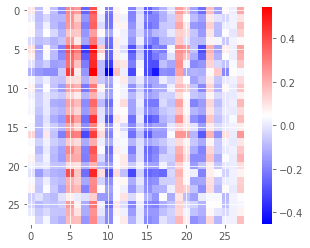

Average Non-Ictal


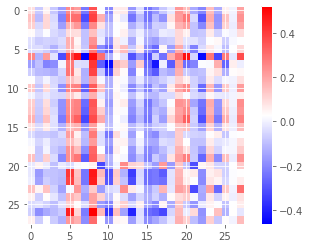

Sample Ictal and Non-Ictal Simularity Matrix for GCN
sample ictal


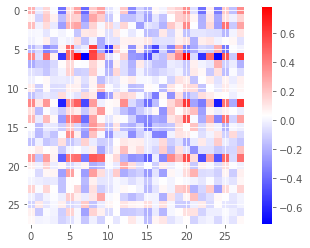

sample Non-Ictal


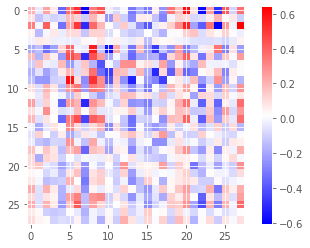

In [538]:
sim_all = {}
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test

# Get simularity matrix from GCN
GCNmodel.eval()
        
sim_all["GCN_train"] = GCNmodel(torch.from_numpy(X_train).float(),
                                        torch.from_numpy(A).float(), tensor).cpu().detach().numpy()
sim_all["GCN_test"] = GCNmodel(torch.from_numpy(X_test).float(),
                                       torch.from_numpy(A).float(), tensor).cpu().detach().numpy()

print("Average Ictal and Non-Ictal Simularity Matrix for GCN")
visualize_avg_sim_matrix(dm, sim_all["GCN_train"], sim_all["GCN_test"])

print("Sample Ictal and Non-Ictal Simularity Matrix for GCN")
visualize_sample_sim_matrix(dm, sim_all["GCN_train"], sim_all["GCN_test"])

In [542]:
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,20], 
    'dropout':[0.3, 0.1],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}

In [543]:
MLPmodelGCN, _, _, MLPcheckpointGCN = MLP.train_MLP2(dm, sim_all["GCN_train"], sim_all["GCN_test"],
                                                            MLPparametersGCN, acc_fn=MLP.auc2, autostop_decay=0.995,
                                                            print_summary=False, verbose=False)

0.463 ----------saved-----------
0.471 ----------saved-----------
0.488 ----------saved-----------
0.507 ----------saved-----------
0.526 ----------saved-----------
0.545 ----------saved-----------
0.556 ----------saved-----------
0.566 ----------saved-----------
0.571 ----------saved-----------
0.578 ----------saved-----------
0.584 ----------saved-----------
0.591 ----------saved-----------
0.593 ----------saved-----------
0.603 ----------saved-----------
0.606 ----------saved-----------
0.607 ----------saved-----------
0.612 ----------saved-----------
0.62 ----------saved-----------
0.621 ----------saved-----------
0.627 ----------saved-----------
0.629 ----------saved-----------
0.63 ----------saved-----------
0.633 ----------saved-----------
0.636 ----------saved-----------
0.639 ----------saved-----------
0.639 ----------saved-----------
0.64 ----------saved-----------
0.64 ----------saved-----------
0.641 ----------saved-----------
0.645 ----------saved-----------
0.651 --------

device set to cuda
threshold: 0.05  validation loss: 0.4008 F1 accuracy 0.316 Precision accuracy 0.201 Recall accuracy 0.737 AUC accuracy: 0.714
device set to cuda
threshold: 0.1  validation loss: 0.4008 F1 accuracy 0.363 Precision accuracy 0.254 Recall accuracy 0.639 AUC accuracy: 0.714
device set to cuda
threshold: 0.15  validation loss: 0.4008 F1 accuracy 0.383 Precision accuracy 0.291 Recall accuracy 0.562 AUC accuracy: 0.714
device set to cuda
threshold: 0.2  validation loss: 0.4008 F1 accuracy 0.395 Precision accuracy 0.325 Recall accuracy 0.505 AUC accuracy: 0.714
device set to cuda
threshold: 0.25  validation loss: 0.4008 F1 accuracy 0.394 Precision accuracy 0.351 Recall accuracy 0.448 AUC accuracy: 0.714
device set to cuda
threshold: 0.3  validation loss: 0.4008 F1 accuracy 0.391 Precision accuracy 0.368 Recall accuracy 0.418 AUC accuracy: 0.714
device set to cuda
threshold: 0.35  validation loss: 0.4008 F1 accuracy 0.401 Precision accuracy 0.411 Recall accuracy 0.392 AUC accu

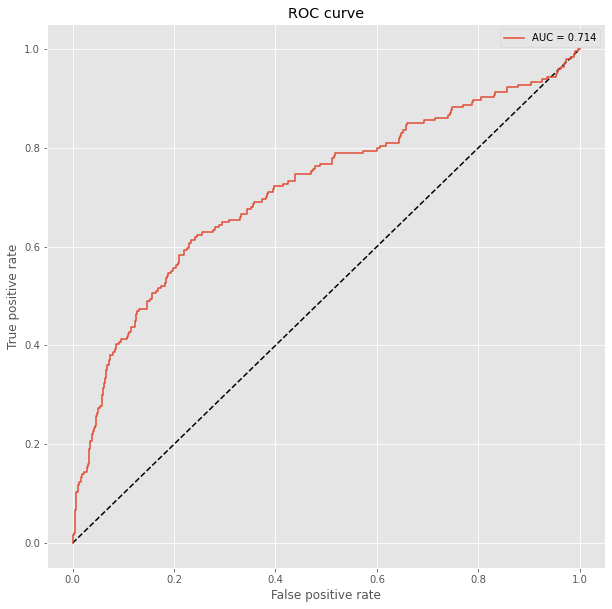

In [544]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPmodelGCN, sim_all["GCN_test"], dm, device_name = 'cuda', threshold = t)
MLP.eval_plot_MLP(MLPmodelGCN, sim_all["GCN_test"], dm, device_name = 'cuda')